Reference: https://www.kaggle.com/datasets/shivamb/netflix-shows/code

In [40]:
# import librairies
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

# Recommendation engine with a graph
>The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.<br/> The more the measure is high, the closest are the two nodes.<br/> The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film

# How to take in account of the description ?

#### First idea ...
> In order to take in account the description, the movie are clustered by applying a KMeans clustering with TF-IDF weights <br/> So two movies that belong in a group of description will share a node.<br/> The fewer the number of films in the group, the more this link will be taken into account 

**but it doesn't work because clusters are too unbalanced*

#### Second idea ...
> In order to take in account the description, calcul the TF-IDF matrix <br/> and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.

I have publish a notebook that explains what is "KMeans clustering with TF-IDF" here :
https://www.kaggle.com/yclaudel/find-similar-articles-with-tf-idf

# Adamic Adar measure
It is a measure used to compute the closeness of nodes based on their shared neighbors.

* x and y are 2 nodes (2 Movies)
* N(one_node) is a function that return the set of adjacent nodes  to one_node

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$

<span>&#171;</span>say otherwise, for each node u in common to x and y, add to the measure 1/log(N(u))<span>&#187;</span>

The quantity $ \frac{1}{log(N(u))} $ determine the importance of u in the measure.
* if x and y share a node u that has a lot of adjacent nodes, this node is not really relevant. <span>&#8594;</span> N(u) is high <span>&#8594;</span> 1/log(N(u)) is not high
* if x and y share a node u that **not** has a lot of adjacent nodes, this node is **really** relevant. <span>&#8594;</span> N(u) is **not** high <span>&#8594;</span> 1/log(N(u)) is higher


In [41]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Load the data

In [42]:
# load the data
df = pd.read_csv('MyDrive/IDS_Datasets/disney_plus_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,2021-11-26,2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!,2021.0,11.0,26.0,"[Alonso Ramirez Ramos, Dave Wasson]","[Animation, Family]","[Chris Diamantopoulos, Tony Anselmo, Tress Mac...",[]
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,2021-11-26,1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...,2021.0,11.0,26.0,[John Cherry],[Comedy],"[Jim Varney, Noelle Parker, Douglas Seale]",[]
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,2021-11-26,2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.,2021.0,11.0,26.0,[Karen Disher],"[Animation, Comedy, Family]","[Raymond Albert Romano, John Leguizamo, Denis ...",[United States]
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,2021-11-26,2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!",2021.0,11.0,26.0,[Hamish Hamilton],[Musical],"[Darren Criss, Adam Lambert, Derek Hough, Alex...",[]
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,2021-11-25,2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...,2021.0,11.0,25.0,[],"[Docuseries, Historical, Music]","[John Lennon, Paul McCartney, George Harrison,...",[]
5,s6,Movie,Becoming Cousteau,Liz Garbus,"Jacques Yves Cousteau, Vincent Cassel",United States,2021-11-24,2021,PG-13,94 min,"Biographical, Documentary",An inside look at the legendary life of advent...,2021.0,11.0,24.0,[Liz Garbus],"[Biographical, Documentary]","[Jacques Yves Cousteau, Vincent Cassel]",[United States]
6,s7,TV Show,Hawkeye,NaN,"Jeremy Renner, Hailee Steinfeld, Vera Farmiga,...",NaN,2021-11-24,2021,TV-14,1 Season,"Action-Adventure, Superhero",Clint Barton/Hawkeye must team up with skilled...,2021.0,11.0,24.0,[],"[Action-Adventure, Superhero]","[Jeremy Renner, Hailee Steinfeld, Vera Farmiga...",[]
7,s8,TV Show,Port Protection Alaska,NaN,"Gary Muehlberger, Mary Miller, Curly Leach, Sa...",United States,2021-11-24,2015,TV-14,2 Seasons,"Docuseries, Reality, Survival",Residents of Port Protection must combat volat...,2021.0,11.0,24.0,[],"[Docuseries, Reality, Survival]","[Gary Muehlberger, Mary Miller, Curly Leach, S...",[United States]
8,s9,TV Show,Secrets of the Zoo: Tampa,NaN,"Dr. Ray Ball, Dr. Lauren Smith, Chris Massaro,...",United States,2021-11-24,2019,TV-PG,2 Seasons,"Animals & Nature, Docuseries, Family",A day in the life at ZooTampa is anything but ...,2021.0,11.0,24.0,[],"[Animals & Nature, Docuseries, Family]","[Dr. Ray Ball, Dr. Lauren Smith, Chris Massaro...",[United States]
9,s10,Movie,A Muppets Christmas: Letters To Santa,Kirk R. Thatcher,"Steve Whitmire, Dave Goelz, Bill Barretta, Eri...",United States,2021-11-19,2008,G,45 min,"Comedy, Family, Musical",Celebrate the holiday season with all your fav...,2021.0,11.0,19.0,[Kirk R. Thatcher],"[Comedy, Family, Musical]","[Steve Whitmire, Dave Goelz, Bill Barretta, Er...",[United States]


In [43]:
print(df.shape)

(1450, 19)


# KMeans clustering with TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(df['description'].apply(lambda x: np.str_(x)) )

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['description'].apply(lambda x: np.str_(x)))
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


55     752
57      52
97      44
114     42
36      28
Name: cluster, dtype: int64

<div class="alert alert-block alert-warning"><span>&#171;</span>column cluster are not going to be used because clusters are two unbalanced <br/> But tfidf will be used in order to find similar description<span>&#187;</span></div>

In [45]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

# Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>


In [46]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.008250951766967773 seconds --
 iter 1000 -- 1.5549190044403076 seconds --
 finish -- 2.1984152793884277 seconds --


# To see what's going on,a sub-graph with only two movies ...

In [47]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



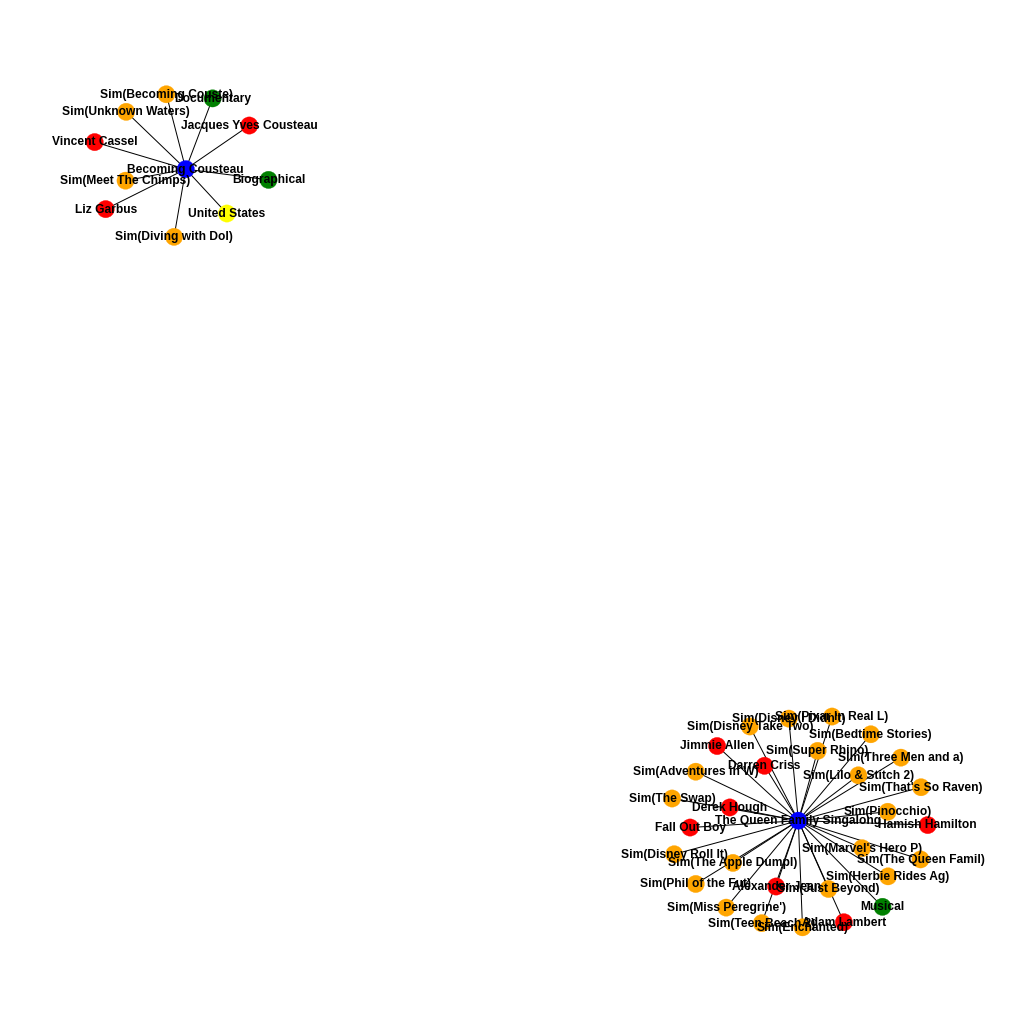

In [49]:
list_in=["Becoming Cousteau","The Queen Family Singalong"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [50]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

# Let's test it ...

In [51]:
result = get_recommendation("The Queen Family Singalong")
result2 = get_recommendation("Becoming Cousteau")
result3 = get_recommendation("Ernest Saves Christmas")
result4 = get_recommendation("Ice Age: A Mammoth Christmas")
print("*"*40+"\n Recommendation for 'The Queen Family Singalong'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Becoming Cousteau'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Ernest Saves Christmas'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Ice Age: A Mammoth Christmas'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'The Queen Family Singalong'
****************************************
Muppets Haunted Mansion                                            1.706952
Pixar In Real Life                                                 1.674332
Disney Take Two With Phineas And Ferb (Shorts)                     1.674332
The Wonderful World of Disney Presents The Little Mermaid Live!    1.442695
Disney I Didn't Do It                                              1.116221
dtype: float64
****************************************
 Recommendation for 'Becoming Cousteau'
****************************************
Marvel Studios: Assembling A Universe    1.451365
Meet The Chimps                          1.257531
Unknown Waters with Jeremy Wade          1.116221
The Hidden Kingdoms of China             0.893254
Diving with Dolphins                     0.893254
dtype: float64
****************************************
 Recommendation for 'Ernest Saves Christmas'
*

# Draw top recommendations, to see the common nodes

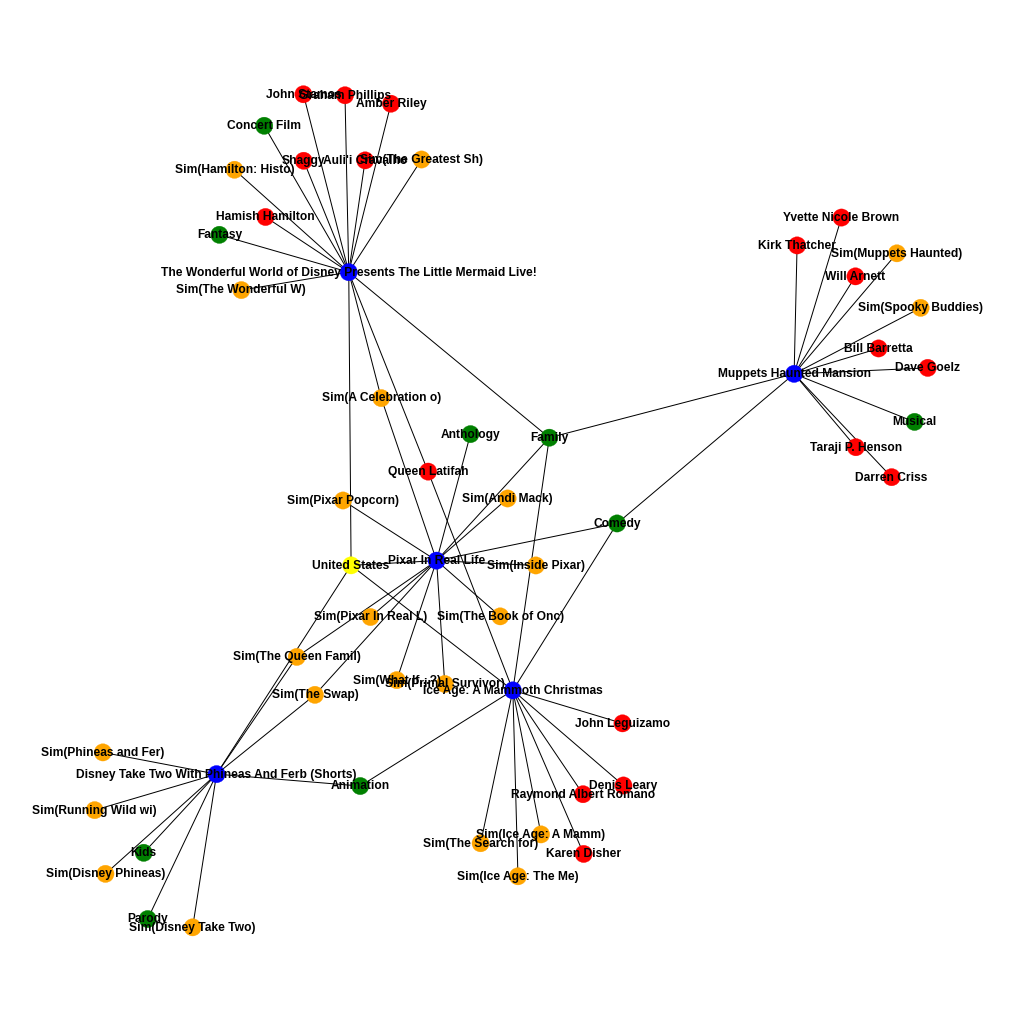

In [53]:
reco=list(result.index[:4].values)
reco.extend(["Ice Age: A Mammoth Christmas"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

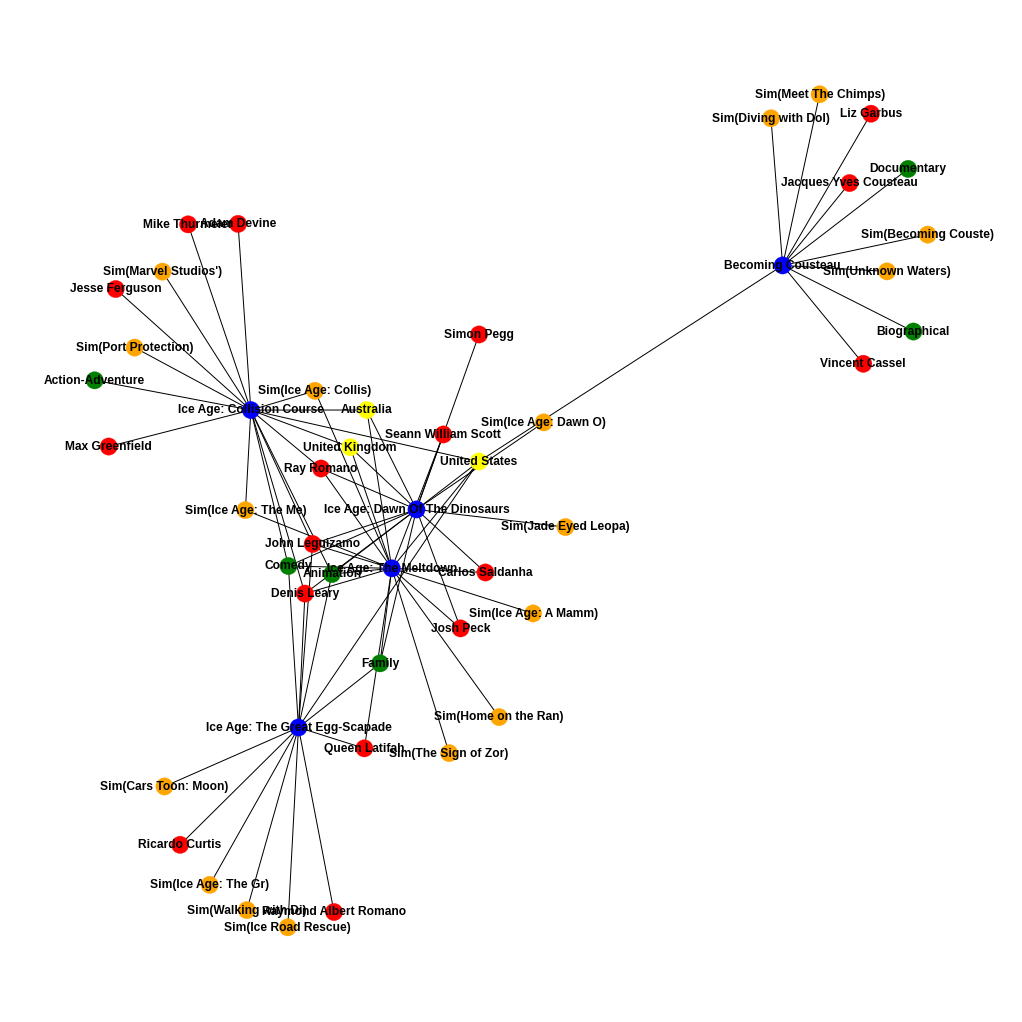

In [54]:
reco=list(result4.index[:4].values)
reco.extend(["Becoming Cousteau"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)